In [ ]:
import os
import kagglehub
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Download latest version
path = kagglehub.dataset_download("stkbailey/nashville-meetup")

print("Path to dataset files:", path)

archivos = os.listdir(path)

for archivo in archivos:
    print(archivo)

Path to dataset files: C:\Users\marco\.cache\kagglehub\datasets\stkbailey\nashville-meetup\versions\5
group-edges.csv
member-edges.csv
member-to-group-edges.csv
meta-events.csv
meta-groups.csv
meta-members.csv
rsvps.csv


In [5]:
# Define las variables de la descarga anterior
path = kagglehub.dataset_download("stkbailey/nashville-meetup")
archivos = os.listdir(path)

# Creamos el diccionario para guardar los DataFrames
dataframes = {} 

print("--- Cargando Archivos ---")

for archivo in archivos:

    df = pd.read_csv(os.path.join(path, archivo))
    
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)
         
    nombre_clave = archivo.replace(".csv", "")

    dataframes[nombre_clave] = df
                
    print(f"✅ Cargado: {nombre_clave}")
    print("-" * 20)

print("--- Carga Completa ---")
print(f"Diccionario de DataFrames creado con las siguientes claves: {dataframes.keys()}")

--- Cargando Archivos ---
✅ Cargado: group-edges
--------------------
✅ Cargado: member-edges
--------------------
✅ Cargado: member-to-group-edges
--------------------
✅ Cargado: meta-events
--------------------
✅ Cargado: meta-groups
--------------------
✅ Cargado: meta-members
--------------------
✅ Cargado: rsvps
--------------------
--- Carga Completa ---
Diccionario de DataFrames creado con las siguientes claves: dict_keys(['group-edges', 'member-edges', 'member-to-group-edges', 'meta-events', 'meta-groups', 'meta-members', 'rsvps'])


In [67]:
for col in dataframes.keys():
    print(col)
    print(dataframes[col].shape)
    
    print(dataframes[col].columns)
    print("-" * 20)

group-edges
(6692, 3)
Index(['group1', 'group2', 'weight'], dtype='object')
--------------------
member-edges
(1176368, 3)
Index(['member1', 'member2', 'weight'], dtype='object')
--------------------
member-to-group-edges
(45583, 3)
Index(['member_id', 'group_id', 'weight'], dtype='object')
--------------------
meta-events
(19307, 4)
Index(['event_id', 'group_id', 'name', 'time'], dtype='object')
--------------------
meta-groups
(602, 7)
Index(['group_id', 'group_name', 'num_members', 'category_id', 'category_name',
       'organizer_id', 'group_urlname'],
      dtype='object')
--------------------
meta-members
(24591, 7)
Index(['member_id', 'name', 'hometown', 'city', 'state', 'lat', 'lon'], dtype='object')
--------------------
rsvps
(126813, 3)
Index(['event_id', 'member_id', 'group_id'], dtype='object')
--------------------


In [86]:
group_edges=dataframes['group-edges'].copy()
member_edges=dataframes['member-edges'].copy()
member_to_group_edges=dataframes['member-to-group-edges'].copy()
meta_events=dataframes['meta-events'].copy()
meta_groups=dataframes['meta-groups'].copy()
meta_members=dataframes['meta-members'].copy()
rsvps=dataframes['rsvps'].copy()

In [87]:
G = nx.from_pandas_edgelist(group_edges, 
                            source='group1', 
                            target='group2', 
                            edge_attr='weight')

print('The group graph has {} nodes and {} edges.'.format(len(G.nodes),
                                                          len(G.edges)))

M = nx.from_pandas_edgelist(member_edges, 
                            source='member1', 
                            target='member2', 
                            edge_attr='weight')

print('The member graph has {} nodes and {} edges.'.format(len(M.nodes),
                                                          len(M.edges)))

E = nx.from_pandas_edgelist(member_to_group_edges, 
                            source='member_id', 
                            target='group_id', 
                            edge_attr='weight')

print('The event graph has {} nodes and {} edges.'.format(len(E.nodes),
                                                          len(E.edges)))

The group graph has 456 nodes and 6692 edges.
The member graph has 11372 nodes and 1176368 edges.
The event graph has 25233 nodes and 45583 edges.


In [88]:
# Calcular la centralidad de grado
degree_centrality = nx.degree_centrality(G)

# Identificar el nodo con mayor centralidad de grado
nodo_mas_central = max(degree_centrality, key=degree_centrality.get)
print(f"El nodo más central es: {nodo_mas_central} con una centralidad de grado de {degree_centrality[nodo_mas_central]:.2f}")

El nodo más central es: 19728145 con una centralidad de grado de 0.40


In [ ]:
df_degree_centrality = pd.DataFrame(
    degree_centrality.items(), 
    columns=['group_id', 'degree_centrality']
)

meta_groups = pd.merge(
    meta_groups,
    df_degree_centrality,
    on='group_id',  # O 'left_on' y 'right_on' si las columnas tienen nombres diferentes
    how='left'
)

In [91]:
meta_groups.isna().sum()

group_id               0
group_name             0
num_members            0
category_id            0
category_name          0
organizer_id           0
group_urlname          0
Degree_Centrality    146
dtype: int64

## Metadatos

In [25]:
groups = dataframes['meta-groups']
members = dataframes['meta-members']

In [31]:
# Distinct groups
print('The number of distinct groups is {}'.format(groups['category_name'].nunique()))


The number of distinct groups is 31


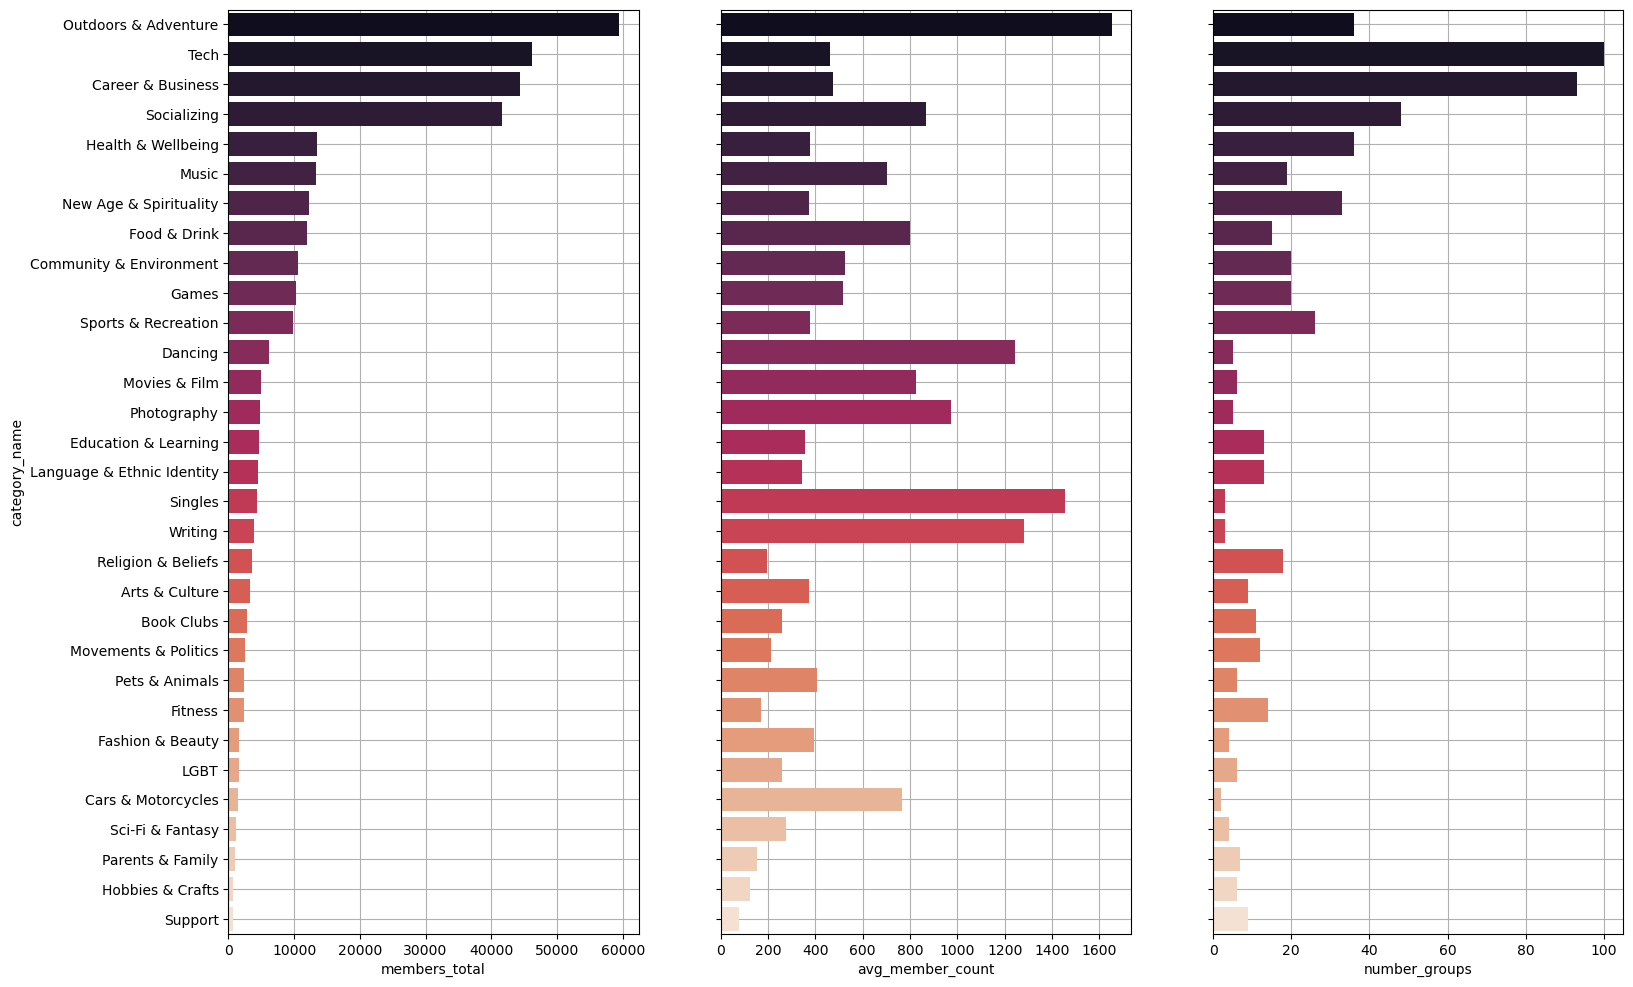

In [ ]:
# aggregate the data that we need.
ordered = groups.groupby(["category_name"]).agg(members_total = ("num_members","sum"), 
                                                avg_member_count = ("num_members", np.average),
                                                number_groups=("group_id", "count")).sort_values(by="members_total", ascending=False)

# instantiate the figure
fig, ax = plt.subplots(1, 3, figsize=(18, 12), sharey=True)
fig.patch.set_facecolor("white")

    
# plot on the axes and show grids
for j, i in enumerate(["members_total", "avg_member_count", "number_groups"]):
    sns.barplot(y=ordered.index, x=i, data=ordered, palette="rocket", ax=ax[j], 
                hue=ordered.index, legend=False) 
    
    ax[j].grid(visible=True)
    ax[j].set_axisbelow(True)

In [30]:
groups

,group_id,group_name,num_members,category_id,category_name,organizer_id,group_urlname
0,339011,Nashville Hiking Meetup,15838,23,Outdoors & Adventure,4353803,nashville-hiking
1,19728145,Stepping Out Social Dance Meetup,1778,5,Dancing,118484462,steppingoutsocialdance
2,6335372,Nashville soccer,2869,32,Sports & Recreation,108448302,Nashville-soccer
3,10016242,NashJS,1975,34,Tech,8111102,nashjs
4,21174496,20's & 30's Women looking for girlfriends,2782,31,Socializing,184580248,new-friends-in-Nashville
...,...,...,...,...,...,...,...
597,23742545,Smyrna Yoga Zumba & Boot Camp Women Only,139,9,Fitness,226783032,Smyrna-Yoga-Zumba-Boot-Camp-Women-Only
598,20647425,ML/JP Dance Music Family,97,21,Music,173945092,ML-JP-Dance-Music-Family
599,22504351,Sumner County Shooters,32,32,Sports & Recreation,6141229,SumnerCountyShooters
600,21686664,Gallatin Makerspace,118,34,Tech,126066112,GallatinMakerspace
